In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import time
import sys
import matplotlib.pyplot as plt
data=pd.read_csv(r'C:\Users\lyxxx\Desktop\solar_dataset\AutoEncoder\AutoEncoder\test.csv',header=None)
data1=np.array(data)

C:\app\anaconda\envs\tensor-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\app\anaconda\envs\tensor-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\app\anaconda\envs\tensor-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\app\anaconda\envs\tensor-gpu\lib\site-packages\tensorflow\python\framework\dtypes.

In [2]:
parameter={'optimizer': 'adam','activation':'leaky-relu' ,'learningrate':0.001,'learningrate2':0.0001,'trainBatchSize':256,'traindatasetSize':1024,'valdatasize':128,'valBatchSize':128,
           'testdatasize':256,'testbatchsize':128,
          'trainingEpoches':1200,'hiddenlayers':[512,32,512,1440]}  #训练集精度最高 7000 epoch ,512 32 512
train_data_original=data[0:1024]    #8:1:3
test_data=data[1152:1408]    #for testing 
val_data2=data[1024:1152]       #for validation
valdatasize=parameter['valdatasize']
testdatasize=parameter['testdatasize']
datasize=parameter['traindatasetSize']
trainBatchSize=parameter['trainBatchSize']
valBatchSize=parameter['valBatchSize']
testbatchsize=parameter['testbatchsize']
totalepoch=parameter['trainingEpoches']
layers=parameter['hiddenlayers']
optimize=parameter['optimizer']
activation=parameter['activation']
learningrate=parameter['learningrate']
inputdimension=train_data_original.shape[1]  #1440
X=tf.placeholder(tf.float32,[trainBatchSize,inputdimension])
Y=tf.placeholder(tf.float32,[valBatchSize,inputdimension])
Z=tf.placeholder(tf.float32,[testbatchsize,inputdimension])
predict_out=tf.placeholder(tf.float32,[trainBatchSize,inputdimension])
actual_out=tf.placeholder(tf.float32,[trainBatchSize,inputdimension])
def xavier_init(n_inputs,n_outputs):  #This method is designed to keep the scale of the gradients roughly the same
                                          #in all layers.
    #init_range=tf.sqrt(6.0/(n_inputs+n_outputs))
    #return -init_range,init_range
    stddev = tf.sqrt(3.0 / (n_inputs + n_outputs))
    return tf.truncated_normal([n_inputs,n_outputs],stddev=stddev)
weights2={
        'layer1':tf.Variable(xavier_init(inputdimension,layers[0])),
        'layer2':tf.Variable(xavier_init(layers[0],layers[1])),
        'layer3':tf.Variable(xavier_init(layers[1],layers[2])),
        'layer4':tf.Variable(xavier_init(layers[2],inputdimension))}
bias4={'layer1':tf.Variable(tf.truncated_normal([layers[0]], stddev=np.sqrt(2/layers[0]))),
     'layer2':tf.Variable(tf.truncated_normal([layers[1]], stddev=np.sqrt(2/layers[1]))),
     'layer3':tf.Variable(tf.truncated_normal([layers[2]], stddev=np.sqrt(2/layers[2]))),
     'layer4':tf.Variable(tf.truncated_normal([layers[3]], stddev=np.sqrt(2/layers[3])))}
train_data=train_data_original/100
def encoder4(x):
    layer1=tf.nn.leaky_relu(tf.add(tf.matmul(x,weights2['layer1']),bias4['layer1']))
    layer2=tf.nn.leaky_relu(tf.add(tf.matmul(layer1,weights2['layer2']),bias4['layer2']))
    layer3=tf.nn.leaky_relu(tf.add(tf.matmul(layer2,weights2['layer3']),bias4['layer3']))
    layer4=tf.nn.leaky_relu(tf.add(tf.matmul(layer3,weights2['layer4']),bias4['layer4']))
    return layer4
#for training 
predict_out=encoder4(X)
actual_out=X
cost=tf.reduce_mean(tf.square(tf.subtract(predict_out,actual_out)))
optimizer=tf.train.AdamOptimizer(learningrate).minimize(cost)

# for validaion
val_out=encoder4(Y)
val=Y
costval=tf.reduce_mean(tf.square(tf.subtract(val_out,val)))

#for test
test_out=encoder4(Z)
t=Z
testval=tf.reduce_mean(tf.square(tf.subtract(test_out,t)))

init=tf.global_variables_initializer()
saver=tf.train.Saver(max_to_keep=100)

out=np.zeros([trainBatchSize,inputdimension])
c=np.zeros([datasize//trainBatchSize])
val_cost=np.zeros(valdatasize//valBatchSize)
test_cost=np.zeros(testdatasize//testbatchsize)


Instructions for updating:
Colocations handled automatically by placer.


In [3]:
cmean=[]
cval=[]
ctest=[]
e=[]

with tf.Session() as sess:
    start=time.time()
    sess.run(init)
    totalBatch=int(datasize/trainBatchSize)
    val_y=val_data2
    print('optimizer:',optimize,' activation function:',activation,' learningrate:',learningrate,' hiddenlayers:',layers)
    for epoch in range(1,totalepoch+1):
        if epoch>=4000:
            learningrate=parameter['learningrate2']
        for i in range(0,datasize,trainBatchSize):
            val_x=train_data[i:i+trainBatchSize]
            _,c[i//trainBatchSize],o=sess.run([optimizer,cost,predict_out],feed_dict={X:val_x})
            
            if epoch==totalepoch:  #获取最后一次训练结束后的输出数据
                if np.all(out==0):
                    out=np.array(o)
                else:
                    out1=np.array(o)
                    out=np.append(out,out1,axis=0)
        #if epoch%1000==0:
            #save_path=saver.save(sess,'mine%d'%epoch)

        if epoch %100==0:
            #save_path=saver.save(sess,'leaky_relu_net%d'%epoch)
            e.append(epoch)
            val_cost=sess.run([costval],feed_dict={Y:val_y})
            cval.append(val_cost)
            for i in range(0,testdatasize,testbatchsize):
                test_z=test_data[i:i+testbatchsize]
                test_cost[i//testbatchsize]=sess.run(testval,feed_dict={Z:test_z})
            ctest.append(test_cost.mean())
            cmean.append(c.mean())
            end=time.time()
            print('epoch:','%04d'%(epoch),
                 'cost=','{:.9f}'.format(c.mean()),'testcost=','{:.6f}'.format(test_cost.mean()),'time:',format(end-start))


optimizer: adam  activation function: leaky-relu  learningrate: 0.001  hiddenlayers: [512, 32, 512, 1440]
epoch: 0100 cost= 0.375779174 testcost= 5252.633057 time: 3.681662082672119
epoch: 0200 cost= 0.299709864 testcost= 4370.927490 time: 6.216537237167358
epoch: 0300 cost= 0.259617593 testcost= 4388.213623 time: 8.71384859085083
epoch: 0400 cost= 0.225273520 testcost= 4830.882324 time: 11.266942739486694
epoch: 0500 cost= 0.178326316 testcost= 4306.980835 time: 13.762534618377686
epoch: 0600 cost= 0.163355567 testcost= 4502.746338 time: 16.238243341445923
epoch: 0700 cost= 0.150876224 testcost= 4716.165039 time: 18.69635033607483
epoch: 0800 cost= 0.129183661 testcost= 4564.233154 time: 21.152721405029297
epoch: 0900 cost= 0.123844706 testcost= 4783.637451 time: 23.606663942337036
epoch: 1000 cost= 0.109158063 testcost= 4778.874512 time: 26.067327737808228
epoch: 1100 cost= 0.119620724 testcost= 4980.970703 time: 28.53023099899292
epoch: 1200 cost= 0.105271304 testcost= 4994.161133 t

In [4]:
cmean=[x*10000 for x in cmean]

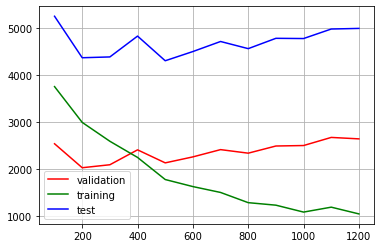

In [5]:
plt.plot(e,cval,'r',label='validation')
plt.plot(e,cmean,'g',label='training')
plt.plot(e,ctest,'b',label='test')
plt.grid()
plt.legend()
plt.show()

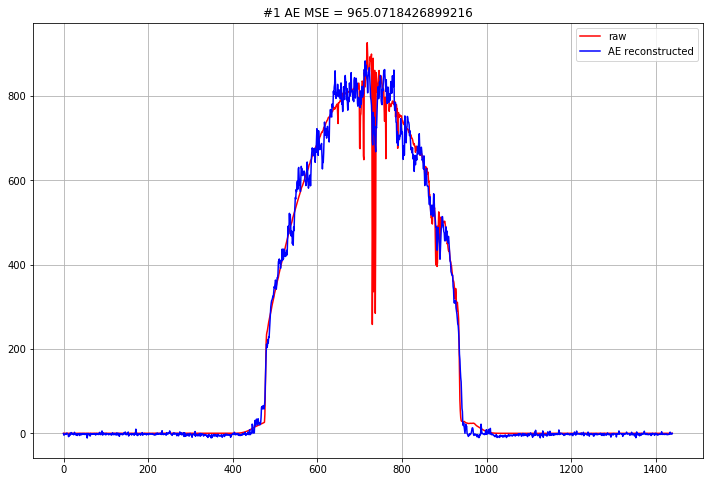

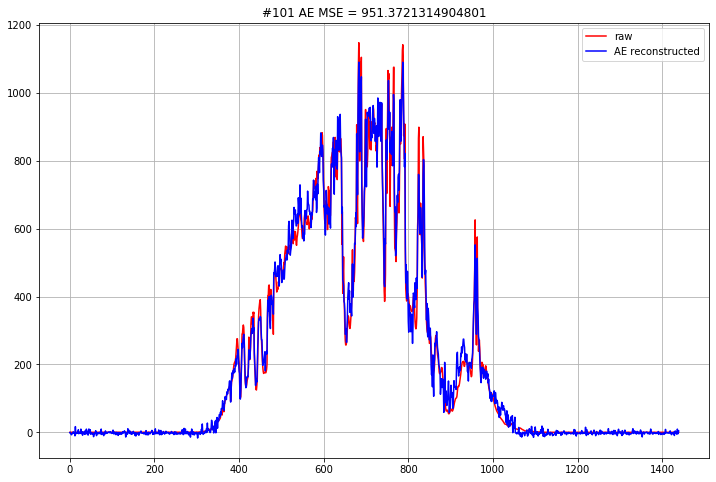

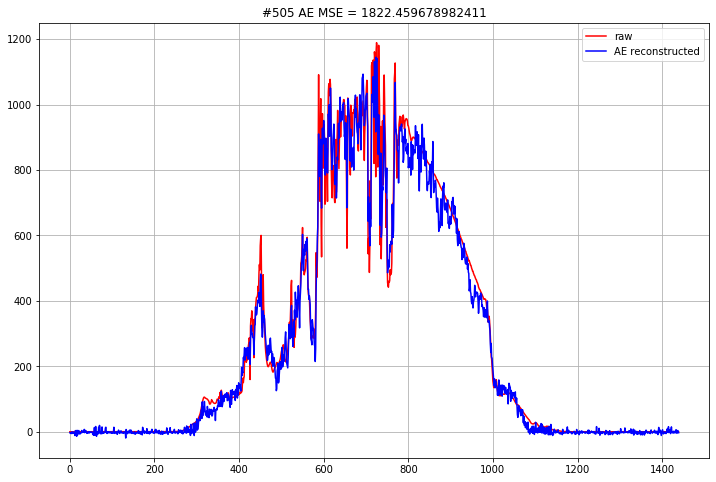

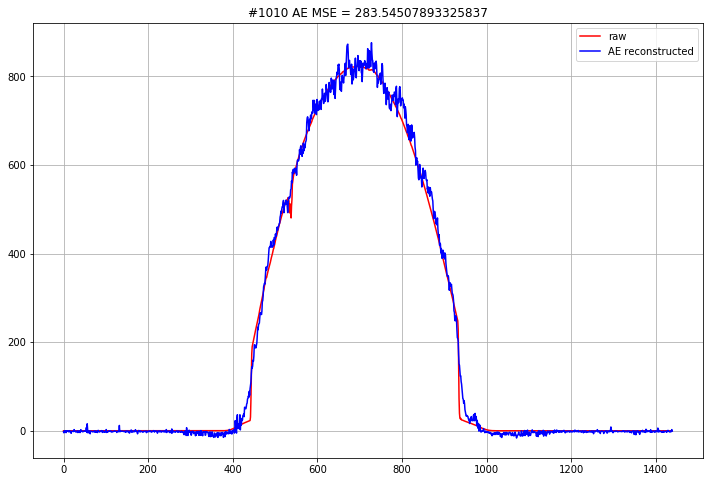

In [16]:
x = range(1440)
#ilist = np.random.randint(1279, size=(6))  ,1290,1360,1410
ilist=[1,101,505,1010] 

# print(ilist)
#print(data[1:2])
for i, idx in enumerate(ilist):
    plt.figure(i, figsize=(12,8))
    plt.plot(x, data1[idx, :], 'r', x, out[idx, :]*100, 'b')
    mse_ae = np.mean(np.square(out[idx, :]*100 - data1[idx, :]))
    plt.title('#{} AE MSE = {}'.format(idx, mse_ae))
    plt.grid(True)
    plt.legend(['raw', 'AE reconstructed'])

plt.show()